In [1]:
import os
import json
import pickle
from bisect import bisect_left, bisect_right
from datetime import datetime, timedelta
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
DATADIR = "hack_data_lenta" # "./data"
clients = pd.read_csv(f"{DATADIR}/clients.csv")
materials = pd.read_csv(f"{DATADIR}/materials.csv")
plants = pd.read_csv(f"{DATADIR}/plants.csv")

In [3]:
transactions = pd.read_parquet(f"{DATADIR}/transactions.parquet")

In [4]:
transactions['date'] = pd.to_datetime(transactions.chq_date)
transactions['year'] = transactions['date'].dt.year 
transactions['month'] = transactions['date'].dt.month 

In [5]:
uniq_chq = transactions.chq_id.unique()
dict_uniq_chq = dict(zip(uniq_chq,range(len(uniq_chq))))
def dict_chq(x):
    return dict_uniq_chq[x]
transactions['chq_id_cat'] = transactions.chq_id.apply(dict_chq)

In [6]:
uniq_mat = transactions.material.unique()
dict_uniq_mat = dict(zip(uniq_mat,range(len(uniq_mat))))
def dict_mat(x):
    return dict_uniq_mat[x]
transactions['material_cat'] = transactions.material.apply(dict_mat)

In [7]:
uniq_clt = transactions.client_id.unique()
dict_uniq_clt = dict(zip(uniq_clt,range(len(uniq_clt))))
def dict_clt(x):
    return dict_uniq_clt[x]
transactions['client_id_cat'] = transactions.client_id.apply(dict_clt)

In [8]:
uniq_plt = transactions.plant.unique()
dict_uniq_plt = dict(zip(uniq_plt,range(len(uniq_plt))))
def dict_plt(x):
    return dict_uniq_plt[x]
transactions['plant_cat'] = transactions.plant.apply(dict_plt)

In [9]:
data = transactions.drop(['chq_id', 'plant', 'chq_date', 'client_id', 'material'], axis=1)

In [10]:
data.head(7)

,chq_position,sales_count,sales_sum,is_promo,date,year,month,chq_id_cat,material_cat,client_id_cat,plant_cat
0,004,2.000,146.98,0,2016-11-01,2016,11,0,0,0,0
1,003,1.000,249.99,1,2016-11-01,2016,11,0,1,0,0
2,012,1.000,47.99,1,2016-11-01,2016,11,0,2,0,0
3,013,1.000,47.99,1,2016-11-01,2016,11,0,2,0,0
4,011,2.000,53.98,1,2016-11-01,2016,11,0,3,0,0
5,001,2.000,64.78,1,2016-11-01,2016,11,0,4,0,0
6,006,0.728,65.51,0,2016-11-01,2016,11,0,5,0,0


In [11]:
cherry_picker = data.groupby(['client_id_cat'])['is_promo'].sum() 

In [12]:
all_ = data.groupby(['client_id_cat'])['is_promo'].count() 
all_ = all_[all_ > 200].index

In [13]:
client_id_cp = cherry_picker[cherry_picker > 200].index

In [14]:
len(client_id_cp), len(all_)

(24771, 48012)

In [15]:
all_ind = [i in all_ for i in data.client_id_cat]
data_all = data[all_ind]

In [16]:
data_all

,chq_position,sales_count,sales_sum,is_promo,date,year,month,chq_id_cat,material_cat,client_id_cat,plant_cat
0,004,2.000,146.98,0,2016-11-01,2016,11,0,0,0,0
1,003,1.000,249.99,1,2016-11-01,2016,11,0,1,0,0
2,012,1.000,47.99,1,2016-11-01,2016,11,0,2,0,0
3,013,1.000,47.99,1,2016-11-01,2016,11,0,2,0,0
4,011,2.000,53.98,1,2016-11-01,2016,11,0,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...
32109409,003,0.795,215.44,1,2016-10-31,2016,10,2964773,43155,2913,187
32109410,001,1.840,34.94,1,2016-10-31,2016,10,2964774,680,64170,187
32109411,003,1.710,32.47,1,2016-10-31,2016,10,2964774,680,64170,187
32109412,004,1.000,21.10,0,2016-10-31,2016,10,2964774,35138,64170,187


In [17]:
data_all['sales_sum'].sum()

3341384613.9800043

In [18]:
cp_mat_ind = [i in client_id_cp for i in data.client_id_cat]
data_cp = data[cp_mat_ind]

In [19]:
data_cp

,chq_position,sales_count,sales_sum,is_promo,date,year,month,chq_id_cat,material_cat,client_id_cat,plant_cat
0,004,2.000,146.98,0,2016-11-01,2016,11,0,0,0,0
1,003,1.000,249.99,1,2016-11-01,2016,11,0,1,0,0
2,012,1.000,47.99,1,2016-11-01,2016,11,0,2,0,0
3,013,1.000,47.99,1,2016-11-01,2016,11,0,2,0,0
4,011,2.000,53.98,1,2016-11-01,2016,11,0,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...
32109405,010,1.000,217.99,0,2016-10-31,2016,10,2964773,24686,2913,187
32109406,006,1.000,161.09,0,2016-10-31,2016,10,2964773,10409,2913,187
32109407,002,1.000,3.49,0,2016-10-31,2016,10,2964773,14,2913,187
32109408,011,1.000,99.99,1,2016-10-31,2016,10,2964773,14625,2913,187


In [20]:
data_notcp = data[~(np.array(cp_mat_ind))]

In [21]:
data_notcp['sales_sum'].sum()

1510645144.02

In [22]:
data_cp['sales_sum'].sum()

2435183442.789998

In [23]:
20127822/(11981592+20127822)

0.6268511159998124

In [24]:
2435183442.789998/(2435183442.789998+1510645144.02)

0.6171538852271128

In [25]:
2435183442.789998/(3341384613.9800043)

0.728794713605086

In [26]:
promo_ = data.groupby(['client_id_cat'])['is_promo'].sum()

In [27]:
all_ = data.groupby(['client_id_cat'])['is_promo'].count()

In [28]:
promo_ = promo_.reset_index()
all_ = all_.reset_index()
promo_ = promo_.merge(all_, on=['client_id_cat'], how='left')

In [29]:
promo_['procent_promo'] = promo_.is_promo_x/promo_.is_promo_y

In [30]:
promo_cp = [i in client_id_cp for i in promo_.client_id_cat]

In [31]:
promo_

,client_id_cat,is_promo_x,is_promo_y,procent_promo
0,0,366,688,0.531977
1,1,116,394,0.294416
2,2,68,155,0.438710
3,3,488,879,0.555176
4,4,560,1452,0.385675
...,...,...,...,...
99995,99995,1,5,0.200000
99996,99996,4,16,0.250000
99997,99997,16,40,0.400000
99998,99998,16,55,0.290909


In [32]:
more_40 = promo_[promo_cp][promo_[promo_cp].procent_promo > 0.4].client_id_cat.index
more_70 = promo_[promo_cp][promo_[promo_cp].procent_promo > 0.7].client_id_cat.index

In [33]:
promo_cp70 = [i in more_70 for i in data.client_id_cat]

In [34]:
data[promo_cp70]

,chq_position,sales_count,sales_sum,is_promo,date,year,month,chq_id_cat,material_cat,client_id_cat,plant_cat
1521,009,1.0,29.99,1,2016-11-01,2016,11,128,1020,107,2
1522,002,2.0,65.98,1,2016-11-01,2016,11,128,1092,107,2
1523,010,1.0,17.99,1,2016-11-01,2016,11,128,1093,107,2
1524,013,1.0,1998.64,1,2016-11-01,2016,11,128,1094,107,2
1525,008,1.0,32.99,1,2016-11-01,2016,11,128,1095,107,2
...,...,...,...,...,...,...,...,...,...,...,...
32109224,003,1.0,69.86,1,2016-10-31,2016,10,2964738,3003,61111,183
32109269,002,1.0,259.03,1,2016-10-31,2016,10,2964749,298,17507,183
32109270,004,1.0,37.99,1,2016-10-31,2016,10,2964749,1086,17507,183
32109271,001,1.0,37.99,1,2016-10-31,2016,10,2964749,1086,17507,183


In [35]:
data['sales_sum'].sum()

3945828586.8100038

In [36]:
data[promo_cp70]['sales_sum'].sum()

159865628.24

In [37]:
159865628.24/2435183442

0.0656482897685537

In [38]:
1289024/20127822

0.06404190180139709

In [39]:
c1 = promo_[promo_cp].procent_promo > 0.4
c2 = promo_[promo_cp].procent_promo < 0.7

more_40_less70 = promo_[promo_cp][c1&c2].client_id_cat.index

In [40]:
promo_cp40_70 = [i in more_40_less70 for i in data.client_id_cat]

In [41]:
data[promo_cp40_70]

,chq_position,sales_count,sales_sum,is_promo,date,year,month,chq_id_cat,material_cat,client_id_cat,plant_cat
0,004,2.000,146.98,0,2016-11-01,2016,11,0,0,0,0
1,003,1.000,249.99,1,2016-11-01,2016,11,0,1,0,0
2,012,1.000,47.99,1,2016-11-01,2016,11,0,2,0,0
3,013,1.000,47.99,1,2016-11-01,2016,11,0,2,0,0
4,011,2.000,53.98,1,2016-11-01,2016,11,0,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...
32109383,004,1.000,47.49,0,2016-10-31,2016,10,2964769,1721,27143,185
32109384,002,1.000,32.99,1,2016-10-31,2016,10,2964767,1185,27143,185
32109385,002,1.000,50.89,0,2016-10-31,2016,10,2964769,4896,27143,185
32109386,003,1.222,23.21,1,2016-10-31,2016,10,2964769,680,27143,185


In [42]:
data

,chq_position,sales_count,sales_sum,is_promo,date,year,month,chq_id_cat,material_cat,client_id_cat,plant_cat
0,004,2.000,146.98,0,2016-11-01,2016,11,0,0,0,0
1,003,1.000,249.99,1,2016-11-01,2016,11,0,1,0,0
2,012,1.000,47.99,1,2016-11-01,2016,11,0,2,0,0
3,013,1.000,47.99,1,2016-11-01,2016,11,0,2,0,0
4,011,2.000,53.98,1,2016-11-01,2016,11,0,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...
32109409,003,0.795,215.44,1,2016-10-31,2016,10,2964773,43155,2913,187
32109410,001,1.840,34.94,1,2016-10-31,2016,10,2964774,680,64170,187
32109411,003,1.710,32.47,1,2016-10-31,2016,10,2964774,680,64170,187
32109412,004,1.000,21.10,0,2016-10-31,2016,10,2964774,35138,64170,187


In [43]:
data[promo_cp40_70]['sales_sum'].sum()

1744908681.5199976

In [44]:
14714579/32109414, 18734/99995,  1744908681.5199976/3945828586.8100038  #from all

(0.45826370422082446, 0.1873493674683734, 0.4422160372989403)

In [45]:
14714579/27413419, 1744908681.5199976/3341384613.9800043  #from all_

(0.5367655526660137, 0.5222112636239127)

In [46]:
14714579/20127822, 1744908681.5199976/2435183442.789998 #from cp200_

(0.7310566935657519, 0.7165409598551022)

In [47]:
plants['plant_cat'] = plants.plant.apply(dict_plt)
plants

,plant,plant_type,city,plant_cat
0,95b09698fda1f64af16708ffb859eab9,HM,St. Petersburg,279
1,926abae84a4bd33c834bc6b981b8cf30,HM,St. Petersburg,280
2,ae2bac2e4b4da805d01b2952d7e35ba4,HM,St. Petersburg,281
3,0e7e3cf0ded4d9db8b376b317c007f99,HM,St. Petersburg,282
4,540bd55a2cf295b8ea9cd78650e89d03,HM,St. Petersburg,283
...,...,...,...,...
383,8178a650c360ce1a3fe81858f0e75760,SM,Other,85
384,238d77348d954fdd455aabb09575f2d0,SM,Other,86
385,6e1acaeb838a890e6570284f73e1d00f,SM,Other,87
386,7fc3ee9aad33036cc501b2ca7c163fc1,SM,Other,88


In [48]:
plants

,plant,plant_type,city,plant_cat
0,95b09698fda1f64af16708ffb859eab9,HM,St. Petersburg,279
1,926abae84a4bd33c834bc6b981b8cf30,HM,St. Petersburg,280
2,ae2bac2e4b4da805d01b2952d7e35ba4,HM,St. Petersburg,281
3,0e7e3cf0ded4d9db8b376b317c007f99,HM,St. Petersburg,282
4,540bd55a2cf295b8ea9cd78650e89d03,HM,St. Petersburg,283
...,...,...,...,...
383,8178a650c360ce1a3fe81858f0e75760,SM,Other,85
384,238d77348d954fdd455aabb09575f2d0,SM,Other,86
385,6e1acaeb838a890e6570284f73e1d00f,SM,Other,87
386,7fc3ee9aad33036cc501b2ca7c163fc1,SM,Other,88


In [49]:
clients['client_id_cat'] = clients.client_id.apply(dict_clt)

In [50]:
clients['client_id_cat'] = clients.client_id.apply(dict_clt)

In [51]:
clients

,client_id,gender,city,birthyear,client_id_cat
0,1a47d62dddacc03fe90c15652f7ae1a4,M,Other,1990.0,56771
1,9cb909f701d25d548e953bff81192b56,F,Other,1969.0,56386
2,d5da0f5b841b4f83383202807995027a,M,Other,1976.0,96019
3,13ed7f16810b17b8cee6de834ac79a48,F,Moscow,1966.0,56249
4,215fe3ea7d5bf0415e5504e2a7f33551,F,Other,1988.0,16994
...,...,...,...,...,...
99990,9e7e66fc2c2dcfd8977bc0cffeff8eb5,M,Other,1985.0,4484
99991,e261c97d40ab839926c712b4aa6cefd8,F,St. Petersburg,1982.0,1074
99992,678ef46f41f8c89f7e8578c9e9592e3e,M,Other,1964.0,77456
99993,274facf0609ceba803f5853bd2222208,F,Other,1951.0,56796


In [52]:
clients_cp40_70 = [i in more_40_less70 for i in clients.client_id_cat]
clients_cp40_70 = clients[clients_cp40_70]

In [53]:
clients_cp40_70.birthyear.describe()

count    18528.000000
mean      1976.225497
std         13.520667
min       1900.000000
25%       1967.000000
50%       1979.000000
75%       1987.000000
max       2009.000000
Name: birthyear, dtype: float64

In [54]:
clients.birthyear.describe()

count    98219.000000
mean      1975.125963
std         14.964637
min       1900.000000
25%       1964.000000
50%       1977.000000
75%       1987.000000
max       2049.000000
Name: birthyear, dtype: float64

In [55]:
clients_cp40_70.city.value_counts()

Other             14556
St. Petersburg     3325
Moscow              853
Name: city, dtype: int64

In [56]:
clients.city.value_counts()

Other             81207
St. Petersburg    13374
Moscow             5414
Name: city, dtype: int64

In [57]:
clients_cp40_70.gender.value_counts()

F    11189
M     7512
Name: gender, dtype: int64

In [58]:
clients.gender.value_counts()

F    59280
M    40360
Name: gender, dtype: int64

In [59]:
data[promo_cp40_70].client_id_cat.nunique()

18736

In [60]:
clients_cp40_70

,client_id,gender,city,birthyear,client_id_cat
8,e2f21dcfe01938a1bf74dc993715c22f,F,Other,1984.0,21308
14,beef839c703bdbd1cfc1c5454732fb50,M,Moscow,1993.0,52686
24,9e7249dd52883fe4fc3cb9f3b26f55cf,M,St. Petersburg,1957.0,54306
31,4650959158cf97a3239bbfd362aa78ef,M,Other,1989.0,83946
36,5fb926087ba1353d1cefdacd170228f1,M,Other,1989.0,77375
...,...,...,...,...,...
99954,2806010f75ad3fc79caa379be60bd4ba,M,Other,1973.0,26799
99955,44185021e56c357c10d4dc716f5bc92a,F,Other,1968.0,35977
99966,f1e563eab9a7df1ce0cc463462054124,M,St. Petersburg,1997.0,24426
99989,1daaf7a4ee2df1b5aeeb8eb42fcea4d7,M,Other,1990.0,24615


In [61]:
data

,chq_position,sales_count,sales_sum,is_promo,date,year,month,chq_id_cat,material_cat,client_id_cat,plant_cat
0,004,2.000,146.98,0,2016-11-01,2016,11,0,0,0,0
1,003,1.000,249.99,1,2016-11-01,2016,11,0,1,0,0
2,012,1.000,47.99,1,2016-11-01,2016,11,0,2,0,0
3,013,1.000,47.99,1,2016-11-01,2016,11,0,2,0,0
4,011,2.000,53.98,1,2016-11-01,2016,11,0,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...
32109409,003,0.795,215.44,1,2016-10-31,2016,10,2964773,43155,2913,187
32109410,001,1.840,34.94,1,2016-10-31,2016,10,2964774,680,64170,187
32109411,003,1.710,32.47,1,2016-10-31,2016,10,2964774,680,64170,187
32109412,004,1.000,21.10,0,2016-10-31,2016,10,2964774,35138,64170,187


In [62]:
date = [(2016,10), (2016,11), (2016,12), (2017,1), (2017,2), (2017,3), (2017,4), (2017,5), (2017,6), (2017,7), (2017,8), (2017,9), (2017,10)]

In [63]:
data40_70 = data[promo_cp40_70]

In [64]:
clients_40_70 = clients_cp40_70.client_id_cat.values
sum_40_70 = np.array([[0] * len(date)] * len(clients_40_70))

In [62]:
num_checked = i
sum_40_70_checked = sum_40_70[:i]

NameError: name 'i' is not defined

In [65]:
sum_40_70_checked, num_checked

NameError: name 'sum_40_70_checked' is not defined

In [ ]:
gp = data40_70.groupby(['client_id_cat', 'chq_id_cat'])['sales_sum'].sum().reset_index()

In [ ]:
data40_70 = data40_70.merge(gp, how='left', on=['client_id_cat', 'chq_id_cat'])

In [ ]:
temp = data40_70.drop_duplicates(subset=['chq_id_cat'])

In [ ]:
gp = temp.groupby(['client_id_cat','year', 'month'])['sales_sum_y'].mean().reset_index()
gp = gp.rename(columns={'sales_sum_y':'sales_aver_month'})

In [ ]:
data40_70 = data40_70.merge(gp, how='left', on = ['client_id_cat','year', 'month'])

In [ ]:
data40_70 = data40_70.drop(['sales_aver_month_x'], axis=1)

In [ ]:
data40_70.to_csv('lenta_data40_70')

In [ ]:
date_start = pd.to_datetime(f'4/10/2016')
date_finish = []
for y, m in date[1:]:
    date_finish.append(pd.to_datetime(f'4/{m}/{y}'))

In [ ]:
date_finish

In [ ]:
gp

In [ ]:
mat_cl = data40_70.groupby(['client_id_cat','material_cat'])['sales_count'].count()
mat_cl = mat_cl.reset_index().rename({'sales_count':'clt_mat_count'})
data40_70 = data40_70.merge(mat_cl, how='left', on = ['client_id_cat','material_cat'])

In [ ]:
data40_70 = data40_70.rename(columns={'sales_count_y':'clt_mat_count'})

In [ ]:
data40_70.groupby['client_id_cat','material_cat']

In [ ]:
data40_70.groupby(['date'])['is_promo'].sum()

In [ ]:
import seaborn as sns

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
gp = data40_70.groupby(['date'])['is_promo'].sum()
gp[gp > 30000]

In [ ]:
data40_70['week'] = data40_70.date.dt.week

In [ ]:
gp44 = data40_70[data40_70['week'] == 44].groupby(['material_cat', 'plant_cat'])['sales_sum_x', 'sales_count_x'].sum().reset_index()

In [ ]:
gp44['mean_price44'] = gp44['sales_sum_x']/gp44['sales_count_x']
gp44 = gp44.rename(columns={'sales_sum_x':'sales_sum_44', 'sales_count_x':'sales_count_44'})

In [ ]:
gp43 = data40_70[data40_70['week'] == 43].groupby(['material_cat', 'plant_cat'])['sales_sum_x', 'sales_count_x'].sum().reset_index()

In [ ]:
gp43['mean_price'] = gp43['sales_sum_x']/gp43['sales_count_x']

In [ ]:
gp43_44 = gp43.merge(gp44, how='left', on=['material_cat', 'plant_cat'])

In [ ]:
gp43_44['proc_price'] = (gp43_44['mean_price44']-gp43_44['mean_price'])/(gp43_44['mean_price'])*100


In [ ]:
gp43_44['proc_sales'] = (gp43_44['sales_count_44']-gp43_44['sales_count_x'])/(gp43_44['sales_count_x'])*100

In [ ]:
gp43_44['Elasticity'] = gp43_44['proc_sales']/gp43_44['proc_price']

In [ ]:
gp43_44['Elasticity'] = gp43_44['Elasticity'].fillna(0).astype(float)

In [ ]:
gp43_44['Elasticity']==np.inf

In [ ]:
inf_id = gp43_44['Elasticity']==np.inf
mininf_id = gp43_44['Elasticity']==-np.inf
gp43_44['Elasticity'][inf_id] = [0]*len(gp43_44['Elasticity']==-np.inf)
gp43_44['Elasticity'][mininf_id] = [0]*len(gp43_44['Elasticity']==-np.inf)


In [ ]:
gp43_44['Elasticity'][inf_id] = [max(gp43_44['Elasticity'])]*len(inf_id)
gp43_44['Elasticity'][mininf_id] = [min(gp43_44['Elasticity'])]*len(mininf_id)

In [ ]:
gp43_44

In [ ]:
count_clt = data40_70['client_id_cat'].value_counts()
data40_70 = data40_70.sort_values(by=['client_id_cat'])
term = data40_70.drop_duplicates(subset=['client_id_cat'])
id_data40_70 = term['client_id_cat'].values

In [ ]:
al_sm = 0
a = np.array([[0]*5]*len(id_data40_70))
for i, id_ in tqdm.tqdm_notebook(enumerate(id_data40_70)):
    count_id = count_clt[id_]
    a[i] = data40_70[al_sm:al_sm+count_id].material_cat.value_counts()[:5].index
    al_sm += count_id

In [ ]:
top_mater = pd.DataFrame(a, index = id_data40_70)

In [ ]:
top_mater['client_id'] = [list(dict_uniq_clt.keys())[clt] for clt in top_mater.index]

In [ ]:
top_mater.to_csv('lenta_top_mat_cat.csv')

In [ ]:
dict_uniq_clt['90fca68123e692a005a4edeadd94b2f2']

In [ ]:
a = np.array([[0]*5]*3)
a[0] = data40_70[0:0+count_id].material_cat.value_counts()[:5].index

In [ ]:
count_id = count_clt[0]
data40_70[0:0+count_id].material_cat.value_counts()[:5].index

<module 'matplotlib.pyplot' from '/usr/local/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

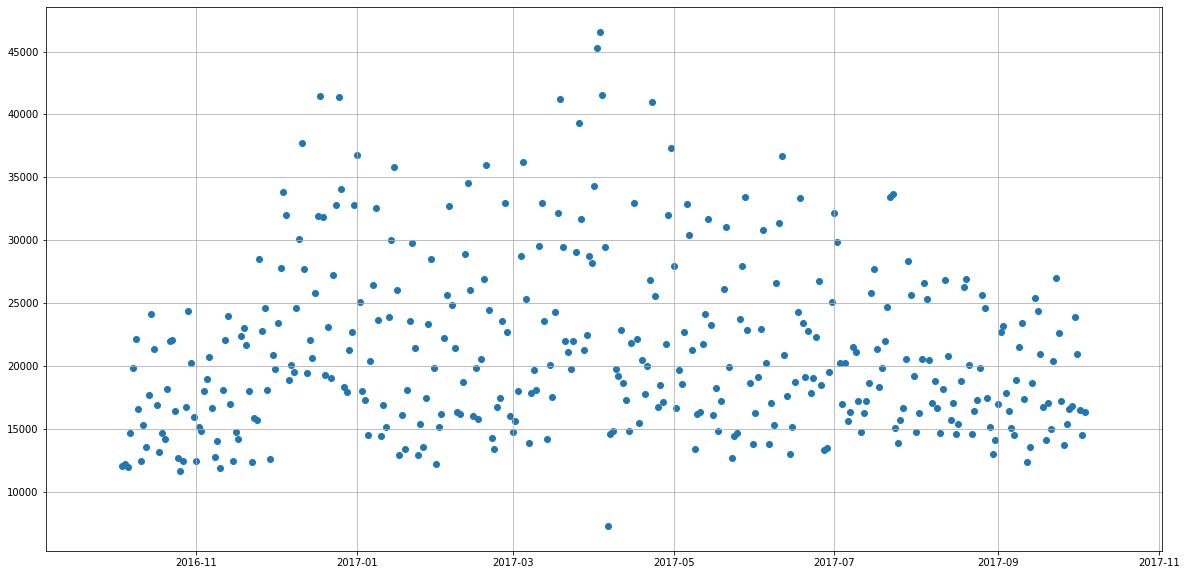

In [229]:
fig = plt.figure(figsize=(20,10))
plt.grid()
plt.scatter(gp.index, data40_70.groupby(['date'])['is_promo'].sum())
plt

In [66]:
clients_cp40_70 = clients_cp40_70.drop(['client_id'], axis=1)

In [67]:
clients_cp40_70

,gender,city,birthyear,client_id_cat
8,F,Other,1984.0,21308
14,M,Moscow,1993.0,52686
24,M,St. Petersburg,1957.0,54306
31,M,Other,1989.0,83946
36,M,Other,1989.0,77375
...,...,...,...,...
99954,M,Other,1973.0,26799
99955,F,Other,1968.0,35977
99966,M,St. Petersburg,1997.0,24426
99989,M,Other,1990.0,24615


In [68]:
data40_70

,chq_position,sales_count,sales_sum,is_promo,date,year,month,chq_id_cat,material_cat,client_id_cat,plant_cat
0,004,2.000,146.98,0,2016-11-01,2016,11,0,0,0,0
1,003,1.000,249.99,1,2016-11-01,2016,11,0,1,0,0
2,012,1.000,47.99,1,2016-11-01,2016,11,0,2,0,0
3,013,1.000,47.99,1,2016-11-01,2016,11,0,2,0,0
4,011,2.000,53.98,1,2016-11-01,2016,11,0,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...
32109383,004,1.000,47.49,0,2016-10-31,2016,10,2964769,1721,27143,185
32109384,002,1.000,32.99,1,2016-10-31,2016,10,2964767,1185,27143,185
32109385,002,1.000,50.89,0,2016-10-31,2016,10,2964769,4896,27143,185
32109386,003,1.222,23.21,1,2016-10-31,2016,10,2964769,680,27143,185


In [310]:
clients_cp40_70['plant_city'] = plants[clients_cp40_70['plant_cat']]

KeyError: 'plant_cat'

In [ ]:
clients_cp40_70

In [69]:
from tqdm import tqdm

In [70]:
clients_40_70 = clients_cp40_70.client_id_cat.values
print(len(clients_40_70))
data40_70 = data[promo_cp40_70]
sum_40_70 = [0] * len(clients_40_70)
for i, client in tqdm(enumerate(clients_40_70)):
    sum_40_70[i] = data40_70[data40_70.client_id_cat==client].sales_sum.sum()

18734


18734it [02:49, 110.77it/s]


In [79]:
city2id = {'Moscow': 0, 'St. Petersburg': 1, 'Other': 2}
plants.city = plants.city.apply(lambda x: city2id.get(x))

In [80]:
city2cat = dict(zip(plants.plant_cat, plants.city))

In [81]:
cherrypickers['plant_city'] = cherrypickers["plant_cat"].apply(lambda x: city2cat.get(x))

In [82]:
cherrypickers

,material_cat,date,plant_cat,sales_count,price,month,is_promo,plant_city
0,0,2016-10-10,1,10.000,73.422000,10,0,1
1,3964,2016-10-10,9,0.332,200.000000,10,0,2
2,3964,2016-10-10,1,1.034,199.990329,10,0,1
3,3963,2016-10-10,297,1.000,64.990000,10,0,2
4,3963,2016-10-10,288,2.000,64.990000,10,0,2
...,...,...,...,...,...,...,...,...
10518185,10292,2017-10-09,116,2.000,30.990000,10,0,2
10518186,2521,2017-10-09,371,1.496,227.419786,10,1,2
10518187,70502,2017-10-09,103,1.000,249.990000,10,0,2
10518188,3396,2017-10-09,17,1.000,34.880000,10,1,2


In [83]:
type2id = {'HM': 0, 'SM': 1}
plants.plant_type = plants.plant_type.apply(lambda x: type2id.get(x))
plant2cat = dict(zip(plants.plant_cat, plants.plant_type))
cherrypickers['plant_type'] = cherrypickers["plant_cat"].apply(lambda x: plant2cat.get(x))
cherrypickers

,material_cat,date,plant_cat,sales_count,price,month,is_promo,plant_city,plant_type
0,0,2016-10-10,1,10.000,73.422000,10,0,1,0
1,3964,2016-10-10,9,0.332,200.000000,10,0,2,0
2,3964,2016-10-10,1,1.034,199.990329,10,0,1,0
3,3963,2016-10-10,297,1.000,64.990000,10,0,2,0
4,3963,2016-10-10,288,2.000,64.990000,10,0,2,0
...,...,...,...,...,...,...,...,...,...
10518185,10292,2017-10-09,116,2.000,30.990000,10,0,2,0
10518186,2521,2017-10-09,371,1.496,227.419786,10,1,2,1
10518187,70502,2017-10-09,103,1.000,249.990000,10,0,2,0
10518188,3396,2017-10-09,17,1.000,34.880000,10,1,2,0


In [84]:
materials['mat_cat'] = materials.material.apply(dict_mat)
food2id = {'NONFOOD': 0, 'FOOD': 1}
materials.hier_level_1 = materials.hier_level_1.apply(lambda x: food2id.get(x))
mat2cat = dict(zip(materials.mat_cat, materials.hier_level_1))
cherrypickers['product_type'] = cherrypickers["material_cat"].apply(lambda x: mat2cat.get(x))
cherrypickers

,material_cat,date,plant_cat,sales_count,price,month,is_promo,plant_city,plant_type,product_type
0,0,2016-10-10,1,10.000,73.422000,10,0,1,0,1.0
1,3964,2016-10-10,9,0.332,200.000000,10,0,2,0,1.0
2,3964,2016-10-10,1,1.034,199.990329,10,0,1,0,1.0
3,3963,2016-10-10,297,1.000,64.990000,10,0,2,0,1.0
4,3963,2016-10-10,288,2.000,64.990000,10,0,2,0,1.0
...,...,...,...,...,...,...,...,...,...,...
10518185,10292,2017-10-09,116,2.000,30.990000,10,0,2,0,1.0
10518186,2521,2017-10-09,371,1.496,227.419786,10,1,2,1,1.0
10518187,70502,2017-10-09,103,1.000,249.990000,10,0,2,0,0.0
10518188,3396,2017-10-09,17,1.000,34.880000,10,1,2,0,1.0


In [85]:
alco2cat = dict(zip(materials.mat_cat, materials.is_alco))
cherrypickers['is_alco'] = cherrypickers["material_cat"].apply(lambda x: alco2cat.get(x))
label2cat = dict(zip(materials.mat_cat, materials.is_private_label))
cherrypickers['is_private_label'] = cherrypickers["material_cat"].apply(lambda x: label2cat.get(x))

In [86]:
uniq_vnd = materials.vendor.unique()
dict_uniq_vnd = dict(zip(uniq_vnd,range(len(uniq_vnd))))
def dict_vnd(x):
    return dict_uniq_vnd[x]
materials['vendor_cat'] = materials.vendor.apply(dict_vnd)

In [87]:
vendor2cat = dict(zip(materials.mat_cat, materials.vendor_cat))
cherrypickers['vendor_cat'] = cherrypickers["material_cat"].apply(lambda x: vendor2cat.get(x))

In [88]:
cherrypickers

,material_cat,date,plant_cat,sales_count,price,month,is_promo,plant_city,plant_type,product_type,is_alco,is_private_label,vendor_cat
0,0,2016-10-10,1,10.000,73.422000,10,0,1,0,1.0,0.0,0.0,1569.0
1,3964,2016-10-10,9,0.332,200.000000,10,0,2,0,1.0,0.0,0.0,63.0
2,3964,2016-10-10,1,1.034,199.990329,10,0,1,0,1.0,0.0,0.0,63.0
3,3963,2016-10-10,297,1.000,64.990000,10,0,2,0,1.0,0.0,1.0,300.0
4,3963,2016-10-10,288,2.000,64.990000,10,0,2,0,1.0,0.0,1.0,300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10518185,10292,2017-10-09,116,2.000,30.990000,10,0,2,0,1.0,0.0,0.0,1630.0
10518186,2521,2017-10-09,371,1.496,227.419786,10,1,2,1,1.0,0.0,0.0,63.0
10518187,70502,2017-10-09,103,1.000,249.990000,10,0,2,0,0.0,0.0,1.0,237.0
10518188,3396,2017-10-09,17,1.000,34.880000,10,1,2,0,1.0,0.0,0.0,271.0


In [64]:
def price_cat(x):
    if x < 0:
        total = -1
    elif x < 250:
        total = 1
    elif x < 550:
        total = 2
    elif x < 1000:
        total = 3
    elif x < 2000:
        total = 4
    elif x>=2000:
        total = 5
    
    return total


In [71]:
cherrypickers = data[promo_cp40_70].groupby(by=['material_cat', pd.Grouper(key='date', freq='1W-MON'), 'plant_cat'])
cherrypickers_sum = cherrypickers['sales_count', 'sales_sum'].sum().sort_values('date').reset_index()

/opt/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [72]:
cherrypickers

In [73]:
cherrypickers_mean = cherrypickers['month', 'is_promo'].max().sort_values('date').reset_index()

/opt/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [74]:
cherrypickers_sum['price'] = cherrypickers_sum['sales_sum'] / cherrypickers_sum['sales_count']
cherrypickers_sum = cherrypickers_sum.drop(['sales_sum'], axis=1)

In [75]:
cherrypickers_sum

,material_cat,date,plant_cat,sales_count,price
0,0,2016-10-10,1,10.000,73.422000
1,3964,2016-10-10,9,0.332,200.000000
2,3964,2016-10-10,1,1.034,199.990329
3,3963,2016-10-10,297,1.000,64.990000
4,3963,2016-10-10,288,2.000,64.990000
...,...,...,...,...,...
10518185,10292,2017-10-09,116,2.000,30.990000
10518186,2521,2017-10-09,371,1.496,227.419786
10518187,70502,2017-10-09,103,1.000,249.990000
10518188,3396,2017-10-09,17,1.000,34.880000


In [76]:
cherrypickers_mean

,material_cat,date,plant_cat,month,is_promo
0,0,2016-10-10,1,10,0
1,3964,2016-10-10,9,10,0
2,3964,2016-10-10,1,10,0
3,3963,2016-10-10,297,10,0
4,3963,2016-10-10,288,10,0
...,...,...,...,...,...
10518185,10292,2017-10-09,116,10,0
10518186,2521,2017-10-09,371,10,1
10518187,70502,2017-10-09,103,10,0
10518188,3396,2017-10-09,17,10,1


In [77]:
cherrypickers = cherrypickers_sum.merge(cherrypickers_mean)

In [78]:
cherrypickers['is_promo'] = cherrypickers['is_promo']

In [336]:
cherrypickers.loc[(cherrypickers['material_cat'] == 0) & (cherrypickers['plant_cat'] == 1)]

,material_cat,date,plant_cat,sales_count,price,month,is_promo,plant_city,plant_type,product_type,is_alco,is_private_label,vendor_cat
0,0,2016-10-10,1,10.0,73.422000,10,0,1,0,1.0,0.0,0.0,1569.0
514270,0,2016-10-24,1,4.0,73.472500,10,0,1,0,1.0,0.0,0.0,1569.0
721264,0,2016-10-31,1,3.0,73.490000,10,0,1,0,1.0,0.0,0.0,1569.0
901079,0,2016-11-07,1,10.0,73.459000,11,0,1,0,1.0,0.0,0.0,1569.0
922236,0,2016-11-14,1,3.0,73.490000,11,0,1,0,1.0,0.0,0.0,1569.0
1260546,0,2016-11-21,1,2.0,73.490000,11,0,1,0,1.0,0.0,0.0,1569.0
1359085,0,2016-11-28,1,6.0,73.490000,11,0,1,0,1.0,0.0,0.0,1569.0
1679325,0,2016-12-05,1,13.0,73.050000,12,0,1,0,1.0,0.0,0.0,1569.0
1854927,0,2016-12-12,1,3.0,73.490000,12,0,1,0,1.0,0.0,0.0,1569.0
2027530,0,2016-12-19,1,5.0,70.930000,12,1,1,0,1.0,0.0,0.0,1569.0


In [331]:
def count_elasticity(price, prev_price, quantity, prev_quantity):
    return ((quantity - prev_quantity) / (quantity)) / ((price - prev_price) / (price))

In [89]:
cherrypickers.to_csv('cherrypickers.csv')

In [132]:
sum_40_70 = np.array([[0] * len(date)] * (len(clients_40_70))-num_checked)
for i, client in tqdm.notebook.tqdm_notebook(enumerate(clients_40_70[i:])):
    j = 0
    for y, m in date:
        c1 = data40_70.year == y
        c2 = data40_70.month == m
        c3 = data40_70.client_id_cat==client
        chq = data40_70[c1&c2&c3].groupby(['chq_id_cat'])['sales_sum'].sum()
        if len(chq)==0:
            sum_40_70[i, j] = 0
        else:
            sum_40_70[i, j] = chq.mean()
        j += 1

KeyboardInterrupt: 

In [133]:
i

2887

In [121]:
a = np.array([[0]*3]*4)

In [2]:
dima_cp = pd.read_csv('cherrypickers.csv')

In [3]:
dima_cp = dima_cp.drop(['Unnamed: 0'], axis=1)

In [4]:
dima_cp

,material_cat,date,plant_cat,sales_count,price,month,is_promo,plant_city,plant_type,product_type,is_alco,is_private_label,vendor_cat
0,0,2016-10-10,1,10.000,73.422000,10,0,1,0,1.0,0.0,0.0,1569.0
1,3964,2016-10-10,9,0.332,200.000000,10,0,2,0,1.0,0.0,0.0,63.0
2,3964,2016-10-10,1,1.034,199.990329,10,0,1,0,1.0,0.0,0.0,63.0
3,3963,2016-10-10,297,1.000,64.990000,10,0,2,0,1.0,0.0,1.0,300.0
4,3963,2016-10-10,288,2.000,64.990000,10,0,2,0,1.0,0.0,1.0,300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10518185,10292,2017-10-09,116,2.000,30.990000,10,0,2,0,1.0,0.0,0.0,1630.0
10518186,2521,2017-10-09,371,1.496,227.419786,10,1,2,1,1.0,0.0,0.0,63.0
10518187,70502,2017-10-09,103,1.000,249.990000,10,0,2,0,0.0,0.0,1.0,237.0
10518188,3396,2017-10-09,17,1.000,34.880000,10,1,2,0,1.0,0.0,0.0,271.0


In [5]:
dima_weeks = dima_cp.date.unique()

In [9]:
dima_cp_next = dima_cp[['material_cat','plant_cat','price','sales_count']]
dima_cp_next = dima_cp_next.rename(columns={'price':'price_next', 'sales_count':'sales_count_next'})

In [10]:
dima_cp_next

,material_cat,plant_cat,price_next,sales_count_next
0,0,1,73.422000,10.000
1,3964,9,200.000000,0.332
2,3964,1,199.990329,1.034
3,3963,297,64.990000,1.000
4,3963,288,64.990000,2.000
...,...,...,...,...
10518185,10292,116,30.990000,2.000
10518186,2521,371,227.419786,1.496
10518187,70502,103,249.990000,1.000
10518188,3396,17,34.880000,1.000


In [11]:
dima_cp_next[(dima_cp_next['material_cat'] == 0) & (dima_cp_next['plant_cat'] == 3)]

,material_cat,plant_cat,price_next,sales_count_next
174793,0,3,73.490000,4.0
321730,0,3,73.490000,1.0
514269,0,3,73.490000,4.0
721263,0,3,73.490000,5.0
901080,0,3,73.490000,6.0
922226,0,3,73.490000,1.0
1260557,0,3,73.490000,4.0
1359084,0,3,73.490000,8.0
1679318,0,3,72.674286,7.0
1854928,0,3,72.161667,6.0


In [12]:
dima_cp[(dima_cp['material_cat'] == 0) & (dima_cp['plant_cat'] == 3)]

,material_cat,date,plant_cat,sales_count,price,month,is_promo,plant_city,plant_type,product_type,is_alco,is_private_label,vendor_cat
174793,0,2016-10-10,3,4.0,73.490000,10,0,1,0,1.0,0.0,0.0,1569.0
321730,0,2016-10-17,3,1.0,73.490000,10,0,1,0,1.0,0.0,0.0,1569.0
514269,0,2016-10-24,3,4.0,73.490000,10,0,1,0,1.0,0.0,0.0,1569.0
721263,0,2016-10-31,3,5.0,73.490000,10,0,1,0,1.0,0.0,0.0,1569.0
901080,0,2016-11-07,3,6.0,73.490000,11,0,1,0,1.0,0.0,0.0,1569.0
922226,0,2016-11-14,3,1.0,73.490000,11,0,1,0,1.0,0.0,0.0,1569.0
1260557,0,2016-11-21,3,4.0,73.490000,11,0,1,0,1.0,0.0,0.0,1569.0
1359084,0,2016-11-28,3,8.0,73.490000,11,0,1,0,1.0,0.0,0.0,1569.0
1679318,0,2016-12-05,3,7.0,72.674286,12,0,1,0,1.0,0.0,0.0,1569.0
1854928,0,2016-12-12,3,6.0,72.161667,12,1,1,0,1.0,0.0,0.0,1569.0


In [13]:
import sys
week = dima_weeks[0]

In [14]:
dima_cp_week = dima_cp.loc[dima_cp['date']==week]
dima_cp_next_w = dima_cp_next.loc[dima_cp['date']==dima_weeks[1]]
dima_cp_week = dima_cp_week.merge(dima_cp_next_w, how='left', on=['material_cat', 'plant_cat'])
dima_cp_week['proc_price'] = (dima_cp_week['price_next']-dima_cp_week['price'])/(dima_cp_week['price'])*100
dima_cp_week['proc_sales'] = (dima_cp_week['sales_count_next']-dima_cp_week['sales_count'])/(dima_cp_week['sales_count'])*100
dima_cp_week['elasticity'] = dima_cp_week['proc_sales']/dima_cp_week['proc_price']
dima_cp_week['elasticity'] = dima_cp_week['elasticity'].fillna(0).astype(float)
inf_id = dima_cp_week['elasticity'] > 1e+14
mininf_id = dima_cp_week['elasticity'] < -1e-14
dima_cp_week['elasticity'][inf_id] = [sys.float_info.max]*len(inf_id)
dima_cp_week['elasticity'][mininf_id] = [-sys.float_info.max]*len(mininf_id)
dima_cp_week['elasticity'][inf_id] = [max(dima_cp_week['elasticity'])]*len(inf_id)
dima_cp_week['elasticity'][mininf_id] = [min(dima_cp_week['elasticity'])]*len(mininf_id)



    

/opt/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

In [15]:
for i, week in tqdm(enumerate(dima_weeks[1:-1])):
    _dima_cp_week = dima_cp[dima_cp['date']==week]
    dima_cp_next_w = dima_cp_next[dima_cp['date']==dima_weeks[i+2]]
    _dima_cp_week = _dima_cp_week.merge(dima_cp_next_w, how='left', on=['material_cat', 'plant_cat'], left_index=True)
    _dima_cp_week['proc_price'] = (_dima_cp_week['price_next']-_dima_cp_week['price'])/(_dima_cp_week['price'])*100
    _dima_cp_week['proc_sales'] = (_dima_cp_week['sales_count_next']-_dima_cp_week['sales_count'])/(_dima_cp_week['sales_count'])*100
    _dima_cp_week['elasticity'] = _dima_cp_week['proc_sales']/_dima_cp_week['proc_price']
    _dima_cp_week['elasticity'] = _dima_cp_week['elasticity'].fillna(0).astype(float)
    inf_id = _dima_cp_week['elasticity'] > 1e+14
    mininf_id = _dima_cp_week['elasticity'] < -1e-14
    _dima_cp_week['elasticity'][inf_id] = [sys.float_info.max]*len(inf_id)
    _dima_cp_week['elasticity'][mininf_id] = [-sys.float_info.max]*len(mininf_id)
    _dima_cp_week['elasticity'][inf_id] = [max(_dima_cp_week['elasticity'])]*len(inf_id)
    _dima_cp_week['elasticity'][mininf_id] = [min(_dima_cp_week['elasticity'])]*len(mininf_id)
    dima_cp_week = pd.concat([dima_cp_week, _dima_cp_week], axis=0, ignore_index=True)

0it [00:00, ?it/s]/opt/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/opt/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

In [31]:
import datetime
dima_cp_week['date_next'] = pd.to_datetime(dima_cp_week['date'] )+datetime.timedelta(days=7)

In [14]:
dima_cp_week.to_csv('dima_cp.csv')

In [15]:
dima_cp_week = pd.read_csv('dima_cp.csv')

In [32]:
dima_cp_week.drop(['Unnamed: 0'], axis=1, inplace=True)

KeyError: "['Unnamed: 0'] not found in axis"

In [16]:
dima_cp_week.dropna()

,material_cat,date,plant_cat,sales_count,price,month,is_promo,plant_city,plant_type,product_type,is_alco,is_private_label,vendor_cat,price_next,sales_count_next,proc_price,proc_sales,elasticity
14,3961,2016-10-10,298,1.000,24.990000,10,0,2,0,1.0,0.0,0.0,516.0,18.990000,1.000,-24.009604,0.000000,-0.000000e+00
20,3964,2016-10-10,36,4.238,181.590373,10,0,2,0,1.0,0.0,0.0,63.0,169.990167,2.034,-6.388117,-52.005663,8.141000e+00
22,3964,2016-10-10,143,3.774,226.746158,10,1,2,0,1.0,0.0,0.0,63.0,170.000000,0.494,-25.026293,-86.910440,3.472765e+00
27,3964,2016-10-10,109,1.067,229.990628,10,0,2,0,1.0,0.0,0.0,63.0,169.991066,3.358,-26.087829,214.714152,-1.797693e+308
35,3964,2016-10-10,45,1.146,199.991274,10,0,2,0,1.0,0.0,0.0,63.0,199.989451,0.948,-0.000911,-17.277487,1.895917e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10465761,44,2017-10-02,48,6.160,54.808442,10,0,2,0,1.0,0.0,0.0,281.0,60.786517,1.068,10.907216,-82.662338,-1.797693e+308
10465782,44,2017-10-02,47,1.402,60.456491,9,0,2,0,1.0,0.0,0.0,281.0,56.887417,2.114,-5.903541,50.784593,-1.797693e+308
10465802,283,2017-10-02,94,8.343,96.546806,10,0,2,0,1.0,0.0,1.0,785.0,98.690958,3.705,2.220842,-55.591514,-1.797693e+308
10465819,12362,2017-10-02,93,3.000,79.880000,9,1,1,0,1.0,0.0,0.0,492.0,79.890000,2.000,0.012519,-33.333333,-1.797693e+308


In [17]:
def elasticity_rct(x):
    if x > 0:
        return 0
    else:
        return 1
        
dima_cp_week['elasticity_reaction'] = dima_cp_week['elasticity'].apply(elasticity_rct)

In [18]:
dima_cp_week.dropna(inplace=True)

In [ ]:
dima_cp_week[(dima_cp_week['material_cat'] == 0) & (dima_cp_week['plant_cat'] == 3)]

In [19]:
to_catboost = dima_cp_week.drop(['sales_count', 'price', 'price_next', 'sales_count_next', 'proc_sales', 'elasticity', 'proc_price'], axis=1)
to_catboost

,material_cat,date,plant_cat,month,is_promo,plant_city,plant_type,product_type,is_alco,is_private_label,vendor_cat,elasticity_reaction
14,3961,2016-10-10,298,10,0,2,0,1.0,0.0,0.0,516.0,1
20,3964,2016-10-10,36,10,0,2,0,1.0,0.0,0.0,63.0,0
22,3964,2016-10-10,143,10,1,2,0,1.0,0.0,0.0,63.0,0
27,3964,2016-10-10,109,10,0,2,0,1.0,0.0,0.0,63.0,1
35,3964,2016-10-10,45,10,0,2,0,1.0,0.0,0.0,63.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10465761,44,2017-10-02,48,10,0,2,0,1.0,0.0,0.0,281.0,1
10465782,44,2017-10-02,47,9,0,2,0,1.0,0.0,0.0,281.0,1
10465802,283,2017-10-02,94,10,0,2,0,1.0,0.0,1.0,785.0,1
10465819,12362,2017-10-02,93,9,1,1,0,1.0,0.0,0.0,492.0,1


In [6]:

to_catboost = pd.read_csv('catboost.csv')

In [7]:
to_catboost

,Unnamed: 0,material_cat,date,plant_cat,month,is_promo,plant_city,plant_type,product_type,is_alco,is_private_label,vendor_cat,elasticity_reaction
0,14,3961,2016-10-10,298,10,0,2,0,1.0,0.0,0.0,516.0,1
1,20,3964,2016-10-10,36,10,0,2,0,1.0,0.0,0.0,63.0,0
2,22,3964,2016-10-10,143,10,1,2,0,1.0,0.0,0.0,63.0,0
3,27,3964,2016-10-10,109,10,0,2,0,1.0,0.0,0.0,63.0,1
4,35,3964,2016-10-10,45,10,0,2,0,1.0,0.0,0.0,63.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2356961,10465761,44,2017-10-02,48,10,0,2,0,1.0,0.0,0.0,281.0,1
2356962,10465782,44,2017-10-02,47,9,0,2,0,1.0,0.0,0.0,281.0,1
2356963,10465802,283,2017-10-02,94,10,0,2,0,1.0,0.0,1.0,785.0,1
2356964,10465819,12362,2017-10-02,93,9,1,1,0,1.0,0.0,0.0,492.0,1


In [21]:
to_catboost.to_csv('catboost.csv')

In [8]:
train_weeks = dima_weeks[:43]
eval_weeks = dima_weeks[43:45]
test_weeks = dima_weeks[45:]
test_weeks

array(['2017-08-21', '2017-08-28', '2017-09-04', '2017-09-11',
       '2017-09-18', '2017-09-25', '2017-10-02', '2017-10-09'],
      dtype=object)

In [9]:
dict_date = dict(zip(dima_weeks,range(len(dima_weeks))))
def dict_dt(x):
    return dict_date[x]
to_catboost['week'] = to_catboost.date.apply(dict_dt)

In [10]:
X_train, y_train = to_catboost[to_catboost['date'].isin(train_weeks)].drop(['elasticity_reaction', 'date'], axis=1), to_catboost[to_catboost['date'].isin(train_weeks)]['elasticity_reaction']
X_val, y_val = to_catboost[to_catboost['date'].isin(eval_weeks)].drop(['elasticity_reaction', 'date'], axis=1), to_catboost[to_catboost['date'].isin(eval_weeks)]['elasticity_reaction']
X_test, y_test = to_catboost[to_catboost['date'].isin(test_weeks)].drop(['elasticity_reaction', 'date'], axis=1), to_catboost[to_catboost['date'].isin(test_weeks)]['elasticity_reaction']

In [11]:
X_train

,Unnamed: 0,material_cat,plant_cat,month,is_promo,plant_city,plant_type,product_type,is_alco,is_private_label,vendor_cat,week
0,14,3961,298,10,0,2,0,1.0,0.0,0.0,516.0,0
1,20,3964,36,10,0,2,0,1.0,0.0,0.0,63.0,0
2,22,3964,143,10,1,2,0,1.0,0.0,0.0,63.0,0
3,27,3964,109,10,0,2,0,1.0,0.0,0.0,63.0,0
4,35,3964,45,10,0,2,0,1.0,0.0,0.0,63.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1978466,8708169,20282,18,7,0,2,0,1.0,0.0,0.0,597.0,42
1978467,8708176,37897,92,7,0,1,0,1.0,0.0,0.0,234.0,42
1978468,8708182,1563,101,7,1,2,0,1.0,0.0,0.0,295.0,42
1978469,8708184,20260,240,7,1,2,0,1.0,0.0,0.0,84.0,42


In [12]:
y_test

2075521    1
2075522    0
2075523    0
2075524    0
2075525    0
          ..
2356961    1
2356962    1
2356963    1
2356964    1
2356965    0
Name: elasticity_reaction, Length: 281445, dtype: int64

In [13]:
from catboost import Pool, CatBoostClassifier

In [14]:
train = Pool(X_train, y_train)
val = Pool(X_val, y_val)

In [15]:
model = CatBoostClassifier(iterations=25000,
                          learning_rate=5e-2, l2_leaf_reg=12.0, loss_function = 'CrossEntropy',
                          depth=10, verbose=True, task_type="GPU",
                           devices='3:5', random_seed=42, eval_metric='AUC')


In [16]:
model.fit(train, eval_set = val)

0:	learn: 0.5816503	test: 0.5812408	best: 0.5812408 (0)	total: 45.8ms	remaining: 19m 5s
1:	learn: 0.5826132	test: 0.5821091	best: 0.5821091 (1)	total: 84.9ms	remaining: 17m 41s
2:	learn: 0.5866985	test: 0.5871778	best: 0.5871778 (2)	total: 122ms	remaining: 16m 56s
3:	learn: 0.5873676	test: 0.5869382	best: 0.5871778 (2)	total: 159ms	remaining: 16m 31s
4:	learn: 0.5868811	test: 0.5866575	best: 0.5871778 (2)	total: 195ms	remaining: 16m 16s
5:	learn: 0.5873752	test: 0.5877194	best: 0.5877194 (5)	total: 232ms	remaining: 16m 5s
6:	learn: 0.5872110	test: 0.5873720	best: 0.5877194 (5)	total: 264ms	remaining: 15m 42s
7:	learn: 0.5885617	test: 0.5886147	best: 0.5886147 (7)	total: 294ms	remaining: 15m 18s
8:	learn: 0.5882947	test: 0.5881537	best: 0.5886147 (7)	total: 324ms	remaining: 14m 59s
9:	learn: 0.5885309	test: 0.5883362	best: 0.5886147 (7)	total: 353ms	remaining: 14m 43s
10:	learn: 0.5883908	test: 0.5882194	best: 0.5886147 (7)	total: 383ms	remaining: 14m 30s
11:	learn: 0.5891173	test: 0.58

In [83]:
features = pd.read_csv('dima_cp.csv')

In [89]:
features

,Unnamed: 0,material_cat,date,plant_cat,sales_count,price,month,is_promo,price_next,sales_count_next,proc_price,proc_sales,elasticity,date_next
0,0,1726,2016-10-17,41,1.718,96.891735,10,0,96.891735,1.718,0.0,0.0,0.0,2016-10-24
1,1,24650,2016-10-17,0,1.000,199.000000,10,0,199.000000,1.000,0.0,0.0,0.0,2016-10-24
2,2,1726,2016-10-17,26,1.484,100.053908,10,0,100.053908,1.484,0.0,0.0,0.0,2016-10-24
3,3,1726,2016-10-17,28,4.114,98.383568,10,0,98.383568,4.114,0.0,0.0,0.0,2016-10-24
4,4,1726,2016-10-17,33,0.200,108.000000,10,0,108.000000,0.200,0.0,0.0,0.0,2016-10-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10479886,181053,4846,2017-10-02,115,2.000,36.990000,9,0,36.990000,2.000,0.0,0.0,0.0,2017-10-09
10479887,181054,283,2017-10-02,79,2.202,113.991826,10,0,113.991826,2.202,0.0,0.0,0.0,2017-10-09
10479888,181055,4959,2017-10-02,101,1.000,109.990000,9,1,109.990000,1.000,0.0,0.0,0.0,2017-10-09
10479889,181056,4790,2017-10-02,195,1.000,199.990000,9,0,199.990000,1.000,0.0,0.0,0.0,2017-10-09


In [86]:
features['elasticity']

0           0.0
1           0.0
2           0.0
3           0.0
4           0.0
           ... 
10479886    0.0
10479887    0.0
10479888    0.0
10479889    0.0
10479890    0.0
Name: elasticity, Length: 10479891, dtype: float64